In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import itertools

Die Simulation basiert auf einer Poisson-Verteilung, welche auf Basis eines Parameters $\lambda$ die Eintrittswahrscheinlichkeit eines ganzzahligen Ereignisses angibt.
$$P_\lambda(k) = \frac{\lambda^k}{k!}\exp{(-\lambda)}$$
in Python durch die Bibliothek `numpy.random` einfach zu realisieren. Dabei wir lediglich der parameter $\lambda$ übergeben. Die Funktion gibt einen Wert zurück, für die Anzahl der Tore $k$. Wird diese Funktion mehrfach aufgerufen, wird eine Poisson-Verteilung erzeugt.

Text(0, 0.5, 'Frequency')

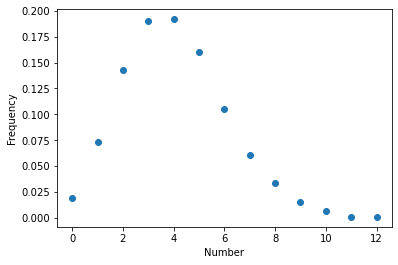

In [2]:
## Demo Poisson-Verteilung
poisson_list = []                                      # leere liste
for i in range(5000):                                  # loop bis für i = 0 ... i = 5000
    poisson_list.append(np.random.poisson(4))          # neuer Listeneintrag am Ende der Liste ("Angehängt")
p, count = np.unique(poisson_list, return_counts=True) # Wie häufig kommt jede Zahl in der Liste vor (Frequency)
plt.scatter(p, count/5000)                             # plot der Verteilung
plt.xlabel("Number")
plt.ylabel("Frequency")

Ein `pandas.DataFrame` enthält die wichtigsten Informationen über die Teams wie Gruppenzugehörigkeit, Tore, Gegentore, Punkte etc. Die Rankings kommen aus dem Netz und müssen 'gescraped' werden. Die Gruppenzugehörigkeiten stehen in einer Excel-Datei "Gruppierung.xlsx" und werden mit der gescrapten Tabelle vereint...

In [3]:
import requests
url = "https://us.soccerway.com/teams/rankings/fifa/"               # URL einer Website mit Team-Rankings

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
} 

r = requests.get(url, headers=header)
df = pd.read_html(r.text)                                           # scraping der Webseite
df = df[0]                                                          # nur Tabelle 1 von Relevanz 
df.drop(columns=["Unnamed: 3", "Change", "#"],axis=1, inplace=True) # Aufräumen
# df.to_csv("FIFA_Rankings_2022.csv", index=False)                  # Speichern
df.rename(columns={"Points": "FIFA_ranking"}, inplace=True)         # Umbenennen ausgewählter Spalten


# Durchschnittliche Tore pro Spiel = 2.64 [https://de.statista.com/statistik/daten/studie/160824/umfrage/tore-pro-spiel-bei-fussball-wm-seit-1930/#:~:text=Diese%20Statistik%20zeigt%20die%20Tore,2%2C64%20Tore%20pro%20Spiel.]
df["xG"] = df.FIFA_ranking/df.FIFA_ranking.max() * 2.64             # Umrechnen der FIFA-Points in xG
grouping = pd.read_excel("Gruppierung.xlsx")                        # Einlesen der Gruppierungen für die Gruppenphase
df = pd.merge(grouping, df)                                         # Zusammenführen der Tabellen, sodass alle Daten in "df" zu finden sind
df.rename(columns={"Gruppe": "group"}, inplace=True)


def reset_dataFrame(df = df):
  '''
  Reset aller Spielergebnisse
  '''
  df["games"] = 0
  df["win"] = 0
  df["loss"] = 0
  df["draw"] = 0
  df["Goals For"] = 0
  df["Goals Against"] = 0
  df["Points"] = 0
  df["Margin"] = 0

reset_dataFrame()
df.head()                                                           # einmal schauen, ob alles geklappt hat

,Team,group,FIFA_ranking,xG,games,win,loss,draw,Goals For,Goals Against,Points,Margin
0,Qatar,A,1441.41,2.070856,0,0,0,0,0,0,0,0
1,Ecuador,A,1463.74,2.102937,0,0,0,0,0,0,0,0
2,Senegal,A,1593.45,2.289290,0,0,0,0,0,0,0,0
3,Netherlands,A,1679.41,2.412788,0,0,0,0,0,0,0,0
4,England,B,1737.46,2.496188,0,0,0,0,0,0,0,0


## Modellierung der Spiele:
Eine Funktion übernimmt die Spiele "an sich". Dazu werden einfach die Tore der Teams mit den vorher berechneten xG als Erwartungswert der Poisson-Funktion $\lambda$ berechnet (`simulate_game`)

Eine Weitere Funktion übernimmt das Updaten der des DataFrames (`game_data_in_Dataframe`)

In [4]:
def simulate_game(team1_xG: float, team2_xG: float) -> list[int]:
    '''
    Utility Funktion zur Bestimmung der Tore beider Teams eines Spiels
    '''
    goals_t1 = np.random.poisson(team1_xG)
    goals_t2 = np.random.poisson(team2_xG)
    return [goals_t1, goals_t2]

def game_data_in_Dataframe(team1: str, team2: str, goals_team1: int, goals_team2: int, dataFrame=df) -> None:
    '''
    Utility Funktion um die Spielergebnisse in das pandas.DataFrame einzupflegen
    '''
    dataFrame.loc[dataFrame.Team == team1, "Goals For"] += goals_team1
    dataFrame.loc[dataFrame.Team == team1, "Goals Against"] += goals_team2
    dataFrame.loc[dataFrame.Team == team2, "Goals For"] += goals_team2
    dataFrame.loc[dataFrame.Team == team2, "Goals Against"] += goals_team1
    dataFrame.loc[dataFrame.Team == team1, "Margin"] += goals_team1 - goals_team2
    dataFrame.loc[dataFrame.Team == team2, "Margin"] += goals_team2 - goals_team1
    if goals_team1 > goals_team2: # Team 1 gewinnt
        dataFrame.loc[dataFrame.Team == team1, "win"] +=1
        dataFrame.loc[dataFrame.Team == team2, "loss"] +=1
    if goals_team1 < goals_team2: # Team 2 gewinnt
        dataFrame.loc[dataFrame.Team == team1, "loss"] += 1
        dataFrame.loc[dataFrame.Team == team2, "win"] += 1
    if goals_team1 == goals_team2: # unentschieden
        dataFrame.loc[dataFrame.Team == team1, "draw"] +=1
        dataFrame.loc[dataFrame.Team == team2, "draw"] +=1
    for team in [team1, team2]: # unabhängig vom Ergebnis...
        dataFrame.loc[dataFrame.Team == team, "games"] +=1
        dataFrame.loc[dataFrame.Team == team, "Points"] = dataFrame.loc[dataFrame.Team == team, "win"]*3 + dataFrame.loc[dataFrame.Team == team, "draw"]

### Gruppenphase
Nur die Spiele der Gruppenphase stehen fest, die restlichen ergeben sich aus deren Ergebnissen. Die Reihenfolge der Siele in der Gruppenphase ist dabei nicht relevant.
________________

Jede Mannschaft muss in der Gruppenphase gegen jede andere Mannschaft einmal Spielen. Die Funktion `itertools.combinations` erzeugt eine Liste aller möglichen Kombinationen der Mannschaften:

In [5]:
def games_group_stage(group):
    '''
    Simulation aller Spiele innerhalb einer Gruppe
    '''
    for t in itertools.combinations(df.loc[df.group == group].Team,2):
        team1, team2 = str(t[0]), str(t[1])
        xG_team1 = df.loc[df.Team == team1].xG
        xG_team2 = df.loc[df.Team == team2].xG
        goals_team1, goals_team2 = simulate_game(xG_team1, xG_team2)
        game_data_in_Dataframe(team1, team2, goals_team1, goals_team2)

Für die Nächste Spielphase, das Achtelfinale werden die Gewinner und die Zweiten der Gruppenphase gebraucht. Diese werden wie folgt ermittelt:
<ol>
<li> Teams mit den Meisten Punkten
<ol>
<li> Pro gewonnenem Spiel gibt es 3 Punkte
<li> Pro unentschiedenem Spiel gibt es 1 Punkt 
<li> Pro verlorenem Spiel gibt es 0 Punkte
</ol>
<li> Teams mit der größten Tordifferenz
<li> Teams mit den meisten Toren aus allen Spielen der Gruppenphase
</ol>

In [6]:
def winner_group_phase(group_name: str):
    '''
    Funktion zur Ermittlung des Gewinnerteams einer Gruppe
    '''
    group_data = df.loc[df.group == group_name]                                                                     # Verglichen werden die Teams innerhalb einer Gruppe
    sorted_by_points = group_data.sort_values(by="Points", ascending=False)                                         # Sortieren nach Punkten (absteigend)
    winner = ""
    if len(sorted_by_points[sorted_by_points["Points"] == sorted_by_points["Points"].iloc[0]]) == 1:                # Wenn der höchste Wert bezüglich Punkte nur 1 mal vorkommt, steht der Gewinner fest
            winner = sorted_by_points.iloc[0]
    else:
            possible_winners = sorted_by_points[sorted_by_points["Points"] == sorted_by_points["Points"].iloc[0]]   # Falls es mehrere Gewinner nach Punkten gibt, werden die punktgleichen Teams 
            sorted_by_margin = possible_winners.sort_values(by="Margin", ascending=False)                           # nach Tordifferenz absteigend sortiert
            if len(sorted_by_margin[sorted_by_margin["Margin"] == sorted_by_margin["Margin"].iloc[0]]) == 1:        # wenn der höchste Wett nur ein mal vorkommt, steht der Gewinner fest
                    winner = sorted_by_margin.iloc[0]
            else:
                    sorted_by_goals_for = possible_winners.sort_values(by="Goals For", ascending=False)             # Falls auch die Bedingung oben scheitert, wird nach Geschossenen Toren geschaut
                    winner = sorted_by_goals_for.iloc[0]                                                            # Der Erste in dieser Liste gewinnt das...eigentlich müsste danach noch nach gelben Karten usw. geschaut werden...
    return winner

def second_group_phase(group_name: str):
    '''
    Funktion zur Ermittlung des zweit platzierten Teams einer Gruppe
    '''
    group_data = df.loc[df.group == group_name]
    second = ""
    sorted_by_points = group_data.sort_values(by="Points", ascending=False)                                                                                             # Sortieren nach Punkten
    if len(sorted_by_points[sorted_by_points["Points"] == sorted_by_points["Points"].max()]) > 1:                                                                       # Wenn mehr als einer höchste Punkte hat, hat der Gruppen Zweite die gleiche Punktzahl wie der Gruppen Erste
            sorted_by_margin = sorted_by_points[sorted_by_points["Points"] == sorted_by_points["Points"].max()].sort_values(by="Margin", ascending=False)               # Dann wird wieder nach Differenz geschaut
            if len(sorted_by_margin[sorted_by_margin["Margin"] == sorted_by_margin["Margin"].max]) > 1:
                    sorted_by_goals_for = sorted_by_margin[sorted_by_margin["Margin"] == sorted_by_margin["Margin"].max].sort_values(by="Goals For", ascending=False)   # Dann nach geschossenen Toren
                    second = sorted_by_goals_for.iloc[1]                                                                                                                # Wenn alle die Kriterien nicht ausreichen, wird halt der Zweite dieser Liste zweiter...
            else: 
                second = sorted_by_margin.iloc[1]                                                                                                                       # Sonst Zweites Element der Liste zweiter
    else:
        second = sorted_by_points.iloc[1]
    return second

### Achtelfinale
Im Achtelfinale gibt es kein Unentschieden mehr! In der Simulation wird das Spiel einfach wiederholt...<br>
Das Achtelfinale gestaltet sich folgendermaßen:

Spiel | Team 1 | Team 2 |
------|--------|--------|
1 | Gewinner A | Zweite B|
2 | Gewinner C | Zweite D|
3 | Gewinner E | Zweite F|
4 | Gewinner G | Zweite H|
5 | Gewinner B | Zweite A|
6 | Gewinner D | Zweite C|
7 | Gewinner F | Zweite E|
8 | Gewinner H | Zweite G|


In [7]:
def games_not_group_stage(names_team1: list[str], names_team2: list[str], winners_list):
    '''
    Funktion zur Simulation von Spielen außerhalb der Gruppenphase
    Params:
    names_team1: Alle Namen der Teams1 in der Reihenfolge der Spiele
    names_team2: Alle Namen der Teams2 in der Reihenfolge der Spiele
    Return:
    winners_list: Liste mit den Namen der Gewinner der Spiele
    '''
    for name_team1, name_team2 in zip(names_team1, names_team2):
        xG_team1 = df.loc[df.Team == name_team1].xG                         # Auslesen der xG beider Teams
        xG_team2 = df.loc[df.Team == name_team2].xG
        goals_team1, goals_team2 = simulate_game(xG_team1, xG_team2)        # Spiel Simulieren
        if goals_team1 == goals_team2:                                      # Kein Unentschieden erlaubt!
            goals_team1, goals_team2 = simulate_game(xG_team1, xG_team2)    # Spiel wiederholen
        if goals_team1 > goals_team2:
            winners_list.append(name_team1)
        else:
            winners_list.append(name_team2)
        game_data_in_Dataframe(name_team1, name_team2, goals_team1, goals_team2)

Der Folgende CodeBlock ruft jetzt die oben definierten Funktionen in der korrekten Reihenfolge auf:

In [8]:
winner = []                                                                        # Array um die Gewinnerteams dokumentieren zu können
for j in range(100):                                                               # Wie oft soll der Worldcup simuliert werden?
    reset_dataFrame()                                                              # SpielDaten zurücksetzten
    for team in df.group.unique():
        games_group_stage(team)                                                    # Spiele der Gruppenphase simulieren
    grouping = ["AB", "CD", "EF", "GH", "BA", "DC", "FE", "HG"]
    list_names_team1 = [winner_group_phase(letter[0]).Team for letter in grouping] # Vorbereiten der Listen für das Achtelfinale
    list_names_team2 = [second_group_phase(letter[1]).Team for letter in grouping]
    winners_round_of_16 = []
    games_not_group_stage(list_names_team1,
                          list_names_team2,
                          winners_round_of_16)                                     # Simulation Achtelfinale

    list_names_team1_quarter = [winners_round_of_16[i] for i in [0,2,4,6]]         # 0 ggn. 1, 2 ggn. 3...
    list_names_team2_quarter = [winners_round_of_16[i] for i in [1,3,5,7]]
    winners_quarter_finals = []
    games_not_group_stage(list_names_team1_quarter,
                          list_names_team2_quarter,
                          winners_quarter_finals)                                  # Simulation Viertelfinale

    list_names_team1_semi = [winners_quarter_finals[i] for i in [0,2]]             # 0 ggn. 1, 2 ggn. 3...
    list_names_team2_semi = [winners_quarter_finals[i] for i in [1,3]]
    winners_semi_finals = []
    games_not_group_stage(list_names_team1_semi,
                          list_names_team2_semi,
                          winners_semi_finals)                                     # Simulation Halbfinale

    list_names_team1_final = [winners_semi_finals[i] for i in [0]]
    list_names_team2_final = [winners_semi_finals[i] for i in [1]]
    winner_finals = []
    games_not_group_stage(list_names_team1_final,
                          list_names_team2_final,
                          winner_finals)

    winner.append(winner_finals[0])                                                # Dokumentation Gewinner
    # df.to_csv(f"games/game_{j}.csv", index=False)                                # Wer will kann jetzt Daten in großen Mengen produzieren^^

## Auswertung
Hier kann man sicher einiges machen......

In [9]:
value, count = np.unique(winner, return_counts=True)
stats = pd.DataFrame()
stats["Team"] = value
stats["win_count"] = count
stats.sort_values(by="win_count", ascending=False, inplace=True)

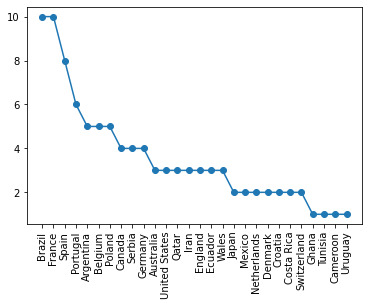

In [10]:
import seaborn as sns
plt.plot(stats.Team, stats.win_count, marker="o")
plt.xticks(rotation=90);